In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import spacy_langdetect
from hashlib import sha256
import string
from wordcloud import WordCloud
from tqdm import tqdm
import seaborn as sns

# Removing non-English words
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

# Kullback-Leibler Divergence
from collections import Counter
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Bigrams and Trigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# LDA
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim

# Parallel Processing
from joblib import Parallel, delayed
import multiprocessing

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:30px ">LOAD THE DATA</h1></center>
</div>

In [7]:
df_top10_filtered = pd.read_csv('df_top10_filtered.csv')
df_top10_filtered.loc[:, 'preprocessed_text_split'] = df_top10_filtered['preprocessed_text'].str.split()
df_top10_filtered.head(3)

,collected_at,metadata_event_time,metadata_event_name,metadata_context_id,metadata_context_role,metadata_user_id,body_assignment_id,body_discussion_topic_id,body_discussion_entry_id,body_submission_id,body_user_id,body_parent_discussion_entry_id,body_text,sentences,sentences_joined,preprocessed_text,kl_divergence,preprocessed_text_split,week_segment
0,2021-09-30 16:07:25,2021-09-30 03:33:28.882000+00:00,discussion_entry_created,id_165820000000017181,StudentEnrollment,id_165820000000031411,NaN,topic_477591,entry_1629821,NaN,user_31411,entry_0,"as an ateneo student, i should strive for exce...","['as an ateneo student, i should strive for ex...","as an ateneo student, i should strive for exce...",ateneo student strive excellence academically ...,5.591669,"[ateneo, student, strive, excellence, academic...",Week 5
1,2021-09-30 16:07:25,2021-09-30 08:40:57.070000+00:00,discussion_entry_created,id_165820000000015636,StudentEnrollment,id_165820000000013516,NaN,topic_468454,entry_1631403,NaN,user_13516,entry_1631213,hi rie! i liked and agree with how you explain...,['i liked and agree with how you explained the...,i liked and agree with how you explained the r...,like agree explain relationship power dynamic ...,3.937162,"[like, agree, explain, relationship, power, dy...",Week 5
2,2021-09-30 16:07:25,2021-09-30 08:47:54.114000+00:00,discussion_entry_created,id_165820000000015636,StudentEnrollment,id_165820000000013592,NaN,topic_468454,entry_1631444,NaN,user_13592,entry_0,"indeed, there is an evident power dynamic betw...","['indeed, there is an evident power dynamic be...","indeed, there is an evident power dynamic betw...",evident power dynamic experimenter participant...,4.012532,"[evident, power, dynamic, experimenter, partic...",Week 5


<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:30px ">CREATE DICTIONARY AND CORPUS</h1></center>
</div>

In [10]:
tokens_list = [text_split for text_split in df_top10_filtered['preprocessed_text_split']]

# create a dictionary and corpus
dictionary = corpora.Dictionary(tokens_list)
corpus = [dictionary.doc2bow(token) for token in tokens_list]

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:30px ">INITIAL: NUMBER OF TOPICS BASED ON THE DATASET</h1></center>
</div>

In [11]:
num_topics_filtered = df_top10_filtered['body_discussion_topic_id'].nunique()
print('Total number of unique topics in the filtered df:', num_topics_filtered)

Total number of unique topics in the filtered df: 1040


In [12]:
num_cores = multiprocessing.cpu_count()

In [13]:
lda_model_1040 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10,
                              num_topics=num_topics_filtered,
                              workers=num_cores-1, passes=15,
                              random_state=42, alpha='asymmetric', eta='auto')

In [14]:
lda_model_1040.print_topics(num_words=15)

[(1035,
  '0.165*"assumption" + 0.038*"firmly" + 0.036*"notification" + 0.024*"refresh" + 0.019*"think" + 0.018*"phone" + 0.014*"use" + 0.013*"relate" + 0.010*"check" + 0.010*"time" + 0.008*"try" + 0.007*"receive" + 0.007*"group" + 0.007*"keep" + 0.006*"like"'),
 (1032,
  '0.179*"merchant" + 0.039*"castilla" + 0.025*"accomplish" + 0.019*"sorsogon" + 0.013*"bike" + 0.011*"equipment" + 0.009*"grabdriver" + 0.009*"instrumentality" + 0.006*"provide" + 0.006*"job" + 0.005*"grabfood" + 0.003*"order" + 0.003*"time" + 0.002*"address" + 0.002*"have"'),
 (1026,
  '0.117*"entity" + 0.058*"nurse" + 0.032*"force" + 0.030*"zalora" + 0.026*"porter" + 0.015*"company" + 0.014*"give" + 0.013*"strategy" + 0.013*"big" + 0.013*"offer" + 0.012*"industry" + 0.012*"e" + 0.011*"player" + 0.011*"influence" + 0.010*"exist"'),
 (1016,
  '0.146*"paper" + 0.119*"evidence" + 0.088*"academic" + 0.026*"claim" + 0.022*"provide" + 0.020*"support" + 0.017*"important" + 0.015*"argument" + 0.013*"idea" + 0.013*"present" + 

In [16]:
# C_v method of computing for the coherence score: higher = better
coherence_model_lda = CoherenceModel(model=lda_model_1040,
                                     texts=tokens_list,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence='c_v')
coherence_model_lda.get_coherence()

0.38251217094716367

<div style='border:2px solid #2C2E4F; padding:15px'>
    <b>Coherence measures how semantically consistent the words within each topic are</b>, reflecting whether the words "make sense" together from a human perspective. It is scored from 0 to 1, where 0 indicates complete incoherence (unrelated words within topics) and 1 denotes high coherence (words are very closely related and meaningful together). A coherence score of 0.38 suggests that the topics are somewhat coherent but not highly interpretable, meaning that while some topics have related words, others might contain unrelated or weakly connected terms.
</div>

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:30px ">ITERATING THROUGH A RANGE OF TOPICS</h1></center>
</div>

<div style='border:2px solid #2C2E4F; padding:15px'>
    We don't recommend not running this again because it takes a while. Figure 1 shows the results. The highest coherence score is 0.43 with two topics.
</div>

In [ ]:
tqdm.pandas(desc="Processing LDA Models")

num_topics = []
min_topics = 2
max_topics = 50
topic_range = range(min_topics, max_topics + 1)
coherence_scores = []
perplexity_scores = []

for i in tqdm(topic_range, desc="Evaluating LDA Models"):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10,
                             num_topics=i, workers=num_cores, passes=15,
                             random_state=42
                            )
    cm = CoherenceModel(model=lda_model, texts=tokens_list,
                        corpus=corpus, dictionary=dictionary, coherence='c_v'
                       )
    perplexity_score = lda_model.log_perplexity(corpus)
    
    num_topics.append(i)
    coherence_scores.append(cm.get_coherence())
    perplexity_scores.append(perplexity_score)

# Plot Coherence Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_topics, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')

# Plot Perplexity Scores
plt.subplot(1, 2, 2)
plt.plot(num_topics, perplexity_scores, marker='o', color='red')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Score vs. Number of Topics')

plt.tight_layout()
plt.show()

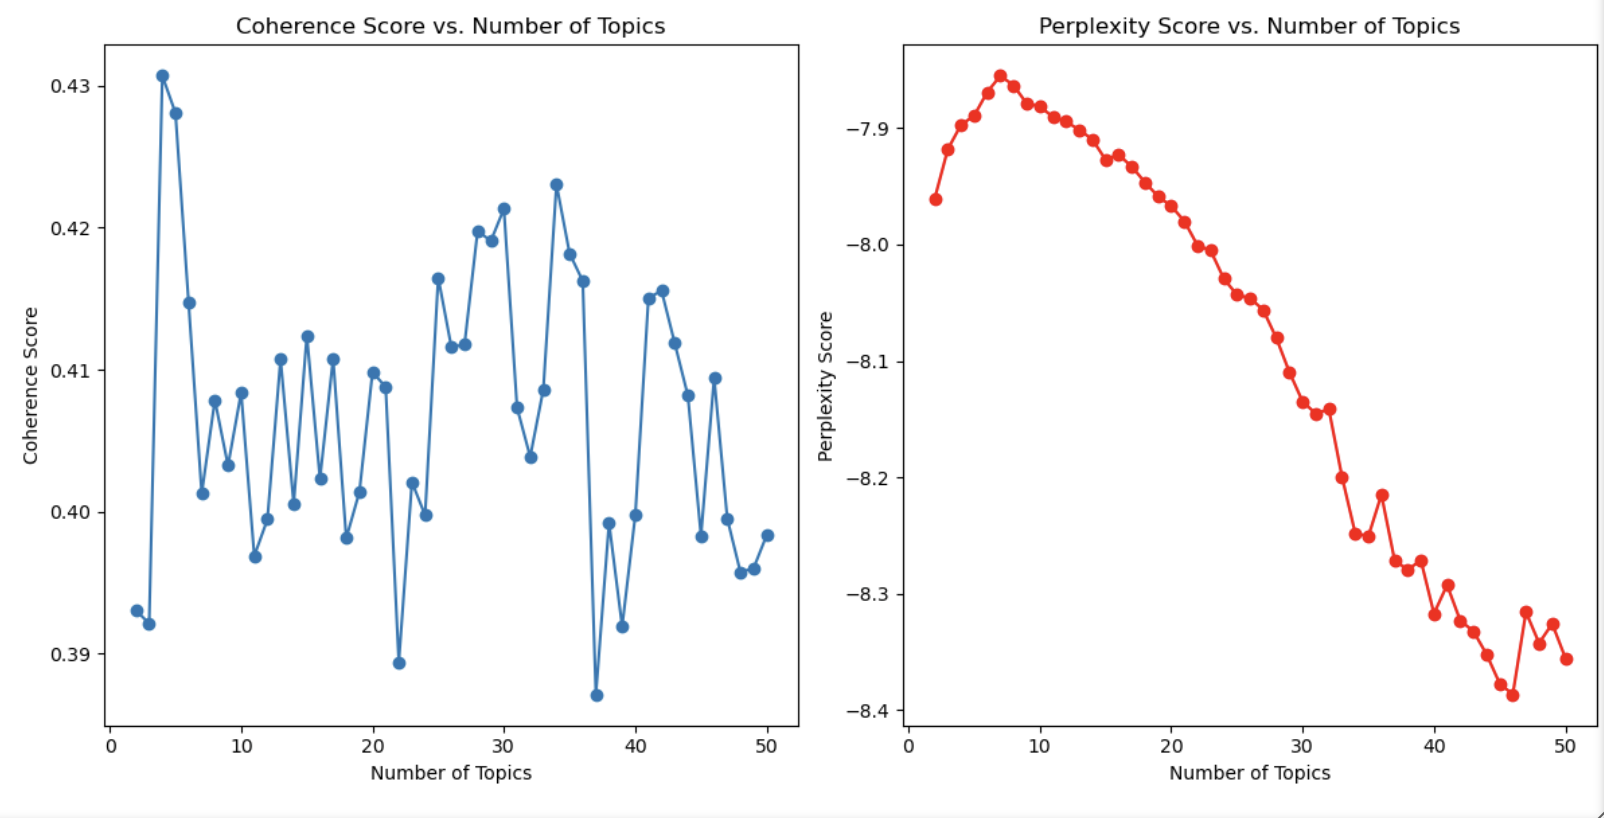

<center><small><b>Figure 1.</b> The Coherence and Perplexity Scores across Different Number of Topics</small></center>

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:30px ">NUMBER OF TOPICS: 2</h1></center>
</div>

In [17]:
lda_model_2 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10,
                           num_topics=2, workers=num_cores-1,
                           passes=15, random_state=42)

In [18]:
lda_model_2.print_topics(num_words=15)

[(0,
  '0.009*"think" + 0.008*"people" + 0.008*"like" + 0.007*"time" + 0.007*"life" + 0.007*"way" + 0.006*"thing" + 0.005*"love" + 0.005*"experience" + 0.005*"learn" + 0.005*"find" + 0.005*"different" + 0.005*"know" + 0.004*"feel" + 0.004*"story"'),
 (1,
  '0.008*"country" + 0.007*"people" + 0.006*"philippine" + 0.005*"government" + 0.004*"need" + 0.004*"think" + 0.004*"pandemic" + 0.004*"work" + 0.004*"business" + 0.003*"good" + 0.003*"time" + 0.003*"social" + 0.003*"able" + 0.003*"give" + 0.003*"development"')]

<div style='border:2px solid #2C2E4F; padding:15px'>
    <b>With only two topics, it’s challenging to capture the full range of ideas and nuances in the data</b>. The limited topics might lead to overly simplistic or generalized results, missing out on important subtleties and variations. This can make it harder to get meaningful insights, as the two topics may not fully represent the complexity and diversity of the content. <b>For this reason, we decided the number of topics with the third highest coherence score, which in this case is 32.</b>
</div>

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:30px ">NUMBER OF TOPICS: 32</h1></center>
</div>

In [19]:
lda_model_32 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10,
                            num_topics=32, workers=num_cores,
                            passes=15, random_state=42)

In [20]:
lda_model_32.print_topics(num_words=15, num_topics=32)

[(0,
  '0.021*"study" + 0.015*"math" + 0.014*"mathematic" + 0.013*"modernity" + 0.013*"research" + 0.010*"modern" + 0.009*"world" + 0.008*"human" + 0.007*"social" + 0.007*"political" + 0.007*"concept" + 0.006*"pattern" + 0.006*"different" + 0.006*"like" + 0.006*"understand"'),
 (1,
  '0.020*"country" + 0.017*"philippine" + 0.015*"government" + 0.009*"education" + 0.008*"people" + 0.007*"development" + 0.007*"poverty" + 0.006*"economic" + 0.006*"state" + 0.006*"need" + 0.005*"issue" + 0.005*"power" + 0.005*"pandemic" + 0.005*"national" + 0.005*"work"'),
 (2,
  '0.023*"communication" + 0.021*"message" + 0.020*"sin" + 0.013*"miscommunication" + 0.012*"people" + 0.011*"way" + 0.010*"communicate" + 0.010*"understand" + 0.009*"video" + 0.008*"person" + 0.008*"human" + 0.008*"think" + 0.008*"model" + 0.007*"affect" + 0.006*"factor"'),
 (3,
  '0.018*"problem" + 0.017*"think" + 0.014*"legal" + 0.013*"research" + 0.013*"source" + 0.012*"starbuck" + 0.011*"law" + 0.011*"management" + 0.010*"desig

<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Visualize the 32 Topics</h3></center>
</div>

In [1]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model_32, corpus, dictionary)
# vis

<div style='border:2px solid #2C2E4F; padding:15px'>
    The analysis of these topics are found in the accompanying PDF file of the report.
</div>